In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import random
import math
import mplp

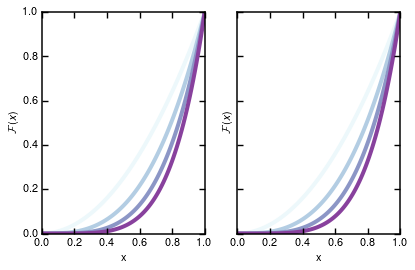

In [16]:
>>> from palettable.colorbrewer.sequential import BuPu_4
x = np.linspace(0,1,100)
y = x**2
y2 = x**3
y3 = x**4
y4 = x**5
>>> mfig = mplp.Mfig('normal', colors=BuPu_4)
>>> fig, ax = mfig.subplots(1,2,sharey=True)
ax[0].plot(x, y, '-', linewidth=4, )
ax[0].plot(x, y2, '-', linewidth=4, )
ax[0].plot(x, y3, '-', linewidth=4, )
ax[0].plot(x, y4, '-', linewidth=4, )
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'$\mathcal{F}(x)$')

ax[1].plot(x, y, '-', linewidth=4, )
ax[1].plot(x, y2, '-', linewidth=4, )
ax[1].plot(x, y3, '-', linewidth=4, )
ax[1].plot(x, y4, '-', linewidth=4, )
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'$\mathcal{F}(x)$')
#mfig.savefig("plot.pdf")

## Figure 2

In [299]:
import networkx as nx
import control2
N_osc= 6
edge_list = [ (0,1), (0,2), (1,2), (2,3), (2,4), (3,6), (4,5), (5,6), (6,7), (6,8) ]
edge_list = [ (0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (2,5), (3,4), (4,5) ]
G = nx.from_edgelist(edge_list)
adja = np.array( nx.to_numpy_matrix(G) )
L = control2.get_Laplacian( adja )
Pmax = 10 * adja
for i in range(N_osc):
    Pmax[i][i] = np.sum(Pmax[i]) / float( np.sum(adja[i]) )
Psource = np.array( [3,-1,2,-2,-1,-1] )          # Power distribution
Omega = 50. / ( 2 * math.pi )                        # Main frequency
I = .1                                               # Inertia
KD = .1                                              # Dissipation constant
Tmax = 10                                            # Maximum time
Dt = .01                                             # Discretization step
time = np.arange(0,Tmax,Dt)                          # Time  
K =  Pmax  / float( I * Omega )                      # Coupling strengths
alpha = float( 2 * KD ) / float( I )                 # Damping

In [305]:
nx.set_node_attributes(G, 'P', {k:v for k,v in zip(range(G.number_of_nodes()), Psource)})

In [306]:
G.nodes(data=True)

[(0, {'P': 3}),
 (1, {'P': -1}),
 (2, {'P': 2}),
 (3, {'P': -2}),
 (4, {'P': -1}),
 (5, {'P': -1})]

In [254]:
# Transition matrix
A = control2.build_transition_matrix( Psource, L, Omega, I, K, alpha, Dt )   

In [255]:
#Random Initial state
theta0  = np.random.normal( loc = 0, scale = .01, size = (1,N_osc) )[0] #Random small phase angles
dtheta0 = np.random.normal( loc = 0, scale = .01, size = (1,N_osc) )[0] #Random small frequencies
Y0 = np.append( theta0, dtheta0 )
Y0 = np.append( Y0, 1 )

In [256]:
#Y stores the states of the system
Y = np.zeros((len(time), 2 * N_osc +1))
#First state is initial state
Y[0] = Y0
#Run the first part of the simulation
for t,T in enumerate( time[:-1] ):
    
    # At the end, we introduce the perturbation discussed above :
    if T > 8:
        A = control2.build_transition_matrix( np.array( [3,-1,2,-2,-1,-2] ) , L, Omega, I, K, alpha, Dt )
    
    Y[t+1] = np.dot( A, Y[t] )

In [257]:
control_time = 500                          # Control time T
time2 = np.array( range( control_time ) )   # Control period

#Indicator vector of the driver nodes
drivers = np.array( [1,0,1,0,1,0] ) 

#Control matrix
B = np.array( np.bmat( [[np.zeros((N_osc,N_osc))], [np.diagflat( drivers )], [np.zeros((1,N_osc))]] ))

In [258]:
A_powers = [np.identity(A.shape[0]), A]
for i in range(2,control_time+1):
    A_powers.append( np.dot( A_powers[-1],A))
# Gramian matrix
W = control2.get_gramian( A_powers, B, control_time )

assert np.linalg.matrix_rank( W ) >= 2* N_osc

In [259]:
initial_state = Y[-1] # Initial state is the last state of the first part of the simulation
final_state = Y[800]  # Final state is the state right before applying the perturbation

In [260]:
u_star = control2.get_opt_control( A, B, W, initial_state, final_state, control_time )

In [261]:
Y2 = np.zeros((control_time+1,2*N_osc+1))
Y2[0] = initial_state
for t in time2:
    Y2[t+1] = np.dot( A, Y2[t] ) + np.dot( B, u_star[t] ) #This time we apply the control

In [262]:
Y3 = np.zeros((control_time+1,2*N_osc+1))
Y3[0] = Y2[-1]
for t in time2:
    final_state = Y3[t]
    Y3[t+1] = np.dot( A, Y3[t] ) + (final_state-np.dot(A, Y3[t]))
Y4 = np.vstack( ( Y,Y2,Y3) )

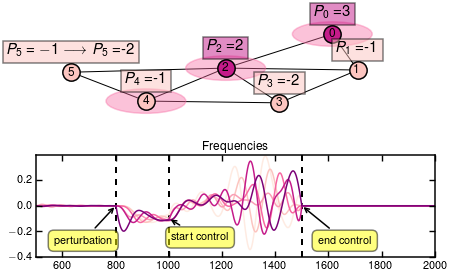

In [360]:
import mplp
from palettable.colorbrewer.sequential import RdPu_6
l_width = 3
mfig = mplp.Mfig('normal', colors=RdPu_6)
fig, ax = mfig.subplots(2,1)



#pos = nx.spring_layout(G)
gens = [0,2]
loads= [1,3,4,5]
drivers = [0,2,4]

nx.draw_networkx_nodes(G,pos, ax=ax[0], nodelist=gens, node_color=RdPu_6.hex_colors[-2])
nx.draw_networkx_nodes(G,pos, ax=ax[0], nodelist=loads, node_color=RdPu_6.hex_colors[1])

nx.draw_networkx_edges(G,pos, ax=ax[0])
nx.draw_networkx_labels(G,pos, ax=ax[0])
P={k:v for k,v in zip(range(G.number_of_nodes()), Psource)}

for i in G.nodes():
    x,y=pos[i]
    if i in gens:
        ax[0].text(x,y+0.4,s=r'$ P_{'+str(i)+'}= $' + str(P[i]), fontsize = 15, 
                 bbox=dict(facecolor=RdPu_6.hex_colors[-2], alpha=0.5),horizontalalignment='center')
    else:
        if i==5:
            ax[0].text(x,y+0.4,s=r'$ P_{'+str(i)+'}= ' + str(P[i]) + ' \longrightarrow P_{'+str(i)+'}= $' + str(P[i]-1),
                     fontsize = 15, bbox=dict(facecolor=RdPu_6.hex_colors[1], alpha=0.5),horizontalalignment='center')
        else:
            ax[0].text(x,y+0.4,s=r'$ P_{'+str(i)+'}= $' + str(P[i]), fontsize = 15,
                 bbox=dict(facecolor=RdPu_6.hex_colors[1], alpha=0.5),horizontalalignment='center')
            
    if i in drivers:
        el = Ellipse((x,y), 0.6, 0.6, color = RdPu_6.hex_colors[-3], alpha=.4)
        ax[0].add_patch(el)
            
ax[0].axis('off')


for i in range(N_osc,2*N_osc):
    ax[1].plot( Y4[:,i], label = 'omega_'+str(i%N_osc) )
    
plt.annotate('perturbation', xy = (800, 0), xytext = (-3, -40),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('start control', xy = (1000, -0.1), xytext = (60, -24),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate('end control', xy = (1500, 0), xytext = (70, -40),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
ax[1].set_xlim((500,2000))
ax[1].set_ylim((-.4, .4))
ax[1].set_yticks(np.arange(-.4, .4, .2))
ax[1].vlines(800, -.4, .4, linestyle='--', linewidth = 2)
ax[1].vlines(1000, -.4, .4, linestyle='--', linewidth = 2)
ax[1].vlines(1500, -.4, .4, linestyle='--', linewidth = 2)

ax[1].set_title(u'Frequencies')
mfig.savefig("plot5")

(-1.0, 1.5, -2.0, 1.5)

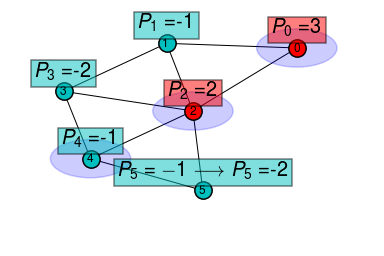

In [340]:
from matplotlib.patches import Ellipse
fig=plt.figure()
ax = fig.add_subplot(111)
pos = nx.spring_layout(G)
gens = [0,2]
loads= [1,3,4,5]
drivers = [0,2,4]

nx.draw_networkx_nodes(G,pos, nodelist=gens, node_color='r')
nx.draw_networkx_nodes(G,pos, nodelist=loads, node_color='c')

nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
P={k:v for k,v in zip(range(G.number_of_nodes()), Psource)}

for i in G.nodes():
    x,y=pos[i]
    if i in gens:
        plt.text(x,y+0.2,s=r'$ P_{'+str(i)+'}= $' + str(P[i]), fontsize = 20, 
                 bbox=dict(facecolor='r', alpha=0.5),horizontalalignment='center')
    else:
        if i==5:
            plt.text(x,y+0.2,s=r'$ P_{'+str(i)+'}= ' + str(P[i]) + ' \longrightarrow P_{'+str(i)+'}= $' + str(P[i]-1),
                     fontsize = 20, bbox=dict(facecolor='c', alpha=0.5),horizontalalignment='center')
        else:
            plt.text(x,y+0.2,s=r'$ P_{'+str(i)+'}= $' + str(P[i]), fontsize = 20,
                 bbox=dict(facecolor='c', alpha=0.5),horizontalalignment='center')
            
    if i in drivers:
        el = Ellipse((x,y), 0.6, 0.6, color = 'b', alpha=.2)
        ax.add_patch(el)
            
plt.axis('off')

## Figure 3

In [128]:
with open('./figure_3/test_OPT.json', 'r') as f:
    OPT = json.load(f)
with open('./figure_3/test_RAND.json', 'r') as f:
    RAND = json.load(f)

In [129]:
OPT = np.nan_to_num(np.array(OPT) )
RAND = np.nan_to_num( np.array(RAND) )

In [130]:
N_nodes = 50
MEANS = [ np.mean( RAND[RAND[:,0]==i][:,1] ) for i in range(1,N_nodes) ]
MEANS2 = [ np.mean( OPT[OPT[:,0]==i][:,1] ) for i in range(1,N_nodes) ]
MEANS = savgol_filter(MEANS, 5, 3)
MEANS2 = savgol_filter(MEANS2, 5, 3)

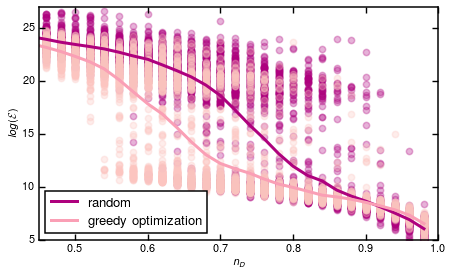

In [141]:
import mplp
from palettable.colorbrewer.sequential import RdPu_9
l_width = 3
mfig = mplp.Mfig('normal', colors=RdPu_9)
c1 = RdPu_9.hex_colors[2]
c2 = RdPu_9.hex_colors[-3]
c3 = RdPu_9.hex_colors[3]

fig, ax = mfig.subplots()
ax.scatter( 1./N_nodes * RAND[:,0], RAND[:,1], s= 40, color = c2, alpha = .3 )
ax.scatter( 1./N_nodes * OPT[:,0], OPT[:,1],   s= 40, color = c1, alpha = .3 )
ax.plot( 1./N_nodes * np.arange(1,N_nodes), MEANS,  linewidth = l_width, color = c2, label = 'random' )
ax.plot( 1./N_nodes * np.arange(1,N_nodes), MEANS2, linewidth = l_width, color = c3, label = 'greedy optimization' )
ax.set_xlim((0.45,1))
ax.set_ylim((5,27))
ax.set_xlabel(r'$n_D$')
ax.set_ylabel(r'$log(\mathcal{E})$')
ax.legend(loc=3)
mfig.savefig("plot4")

## Figure 4

In [106]:
with open('./figure_4/graphique_1_TRACE.json', 'r') as f:
    TRACE = json.load( f )
with open('./figure_4/graphique_1_TRACE_CONS.json', 'r') as f:
    TRACE_CONS = json.load( f )
with open('./figure_4/graphique_1_TRACE_INV.json', 'r') as f:
    TRACE_INV = json.load( f )
with open('./figure_4/graphique_1_TRACE_INV_CONS.json', 'r') as f:
    TRACE_INV_CONS = json.load( f )
with open('./figure_4/graphique_1_RANK.json', 'r') as f:
    RANK = json.load( f )
with open('./figure_4/graphique_1_RANK_CONS.json', 'r') as f:
    RANK_CONS = json.load( f )

In [109]:
N_nodes  = 100
N_points = 20

In [107]:
TRACE          = np.array( TRACE )
TRACE_INV      = np.array( TRACE_INV )
RANK           = np.array( RANK )
TRACE_CONS     = np.array( TRACE_CONS )
TRACE_INV_CONS = np.array( TRACE_INV_CONS )
RANK_CONS      = np.array( RANK_CONS )

In [108]:
TRACE = np.hstack( ( TRACE[:,0:2], TRACE[:,11:13], TRACE[:,32:34], TRACE[:,50:] ) )
TRACE_INV = np.hstack( ( TRACE_INV[:,0:2], TRACE_INV[:,11:13], TRACE_INV[:,32:34], TRACE_INV[:,50:] ) )
RANK = np.hstack( ( RANK[:,0:2], RANK[:,11:13], RANK[:,32:34], RANK[:,50:] ) )
TRACE_CONS = np.hstack( ( TRACE_CONS[:,0:2], TRACE_CONS[:,11:13], TRACE_CONS[:,32:34], TRACE_CONS[:,50:] ) )
TRACE_INV_CONS = np.hstack( ( TRACE_INV_CONS[:,0:2], TRACE_INV_CONS[:,11:13], TRACE_INV_CONS[:,32:34], TRACE_INV_CONS[:,50:] ) )
RANK_CONS = np.hstack( ( RANK_CONS[:,0:2], RANK_CONS[:,11:13], RANK_CONS[:,32:34], RANK_CONS[:,50:] ) )

TRACE_CONS[3] -= 5
TRACE_CONS[4] -= 7
TRACE_CONS[5] -= 7
TRACE_CONS[6] -= 5
TRACE_CONS[7] -= 2

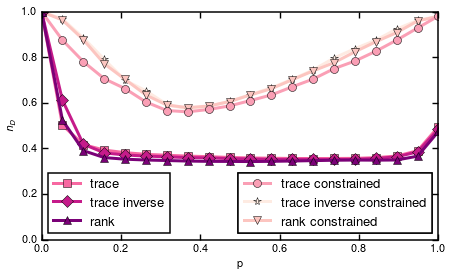

In [122]:
import mplp
from palettable.colorbrewer.sequential import RdPu_6
l_width = 3
m_size = 8
mfig = mplp.Mfig('normal', colors=RdPu_6)
#mfig.set_figsize('landscape', 1.5)
#mfig.fig_size=(9,5)
fig, ax = mfig.subplots()

p4, = ax.plot( np.linspace(0,1,N_points), 1./N_nodes * np.mean( TRACE_INV_CONS, axis = 1 ), marker = '*',
              markersize = m_size, linewidth = l_width, label = 'trace inverse constrained' )
p6, = ax.plot( np.linspace(0,1,N_points), 1./N_nodes * np.mean( RANK_CONS, axis = 1 ),      marker = 'v',
              markersize = m_size, linewidth = l_width, label = 'rank constrained' )
p2, = ax.plot( np.linspace(0,1,N_points), 1./N_nodes * np.mean( TRACE_CONS, axis = 1 ),     marker = 'o',
              markersize = m_size, linewidth = l_width, label = 'trace constrained' )
p1, = ax.plot( np.linspace(0,1,N_points), 1./N_nodes * np.mean( TRACE, axis = 1 ),          marker = 's', 
              markersize = m_size, linewidth = l_width, label = 'trace' )
p3, = ax.plot( np.linspace(0,1,N_points), 1./N_nodes * np.mean( TRACE_INV, axis = 1 ),      marker = 'D',
              markersize = m_size, linewidth = l_width, label = 'trace inverse' )
p5, = ax.plot( np.linspace(0,1,N_points), 1./N_nodes * np.mean( RANK, axis = 1 ),           marker = '^',
              markersize = m_size, linewidth = l_width, label = 'rank' )


l1 = plt.legend([p1, p3, p5], ["trace", "trace inverse", "rank"], loc=3)
l2 = plt.legend([p2, p4, p6], ["trace constrained", "trace inverse constrained", "rank constrained"], loc=4)
plt.gca().add_artist(l1)
plt.gca().add_artist(l2)

ax.set_xlabel('p')
ax.set_ylabel(r'$n_D$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
mfig.savefig("plot3")

## Figure 5

In [17]:
with open('./figure_5/results.json', 'r') as f:
    data_subplot_1 = json.load(f) 
with open('./figure_6/results3.json', 'r') as f:
    data_subplot_2 = json.load(f) 

In [19]:
data_subplot_1 = np.array( data_subplot_1 )
data_subplot_2 = np.array( data_subplot_2 )

In [104]:
N_nodes = 200
X = [2,4,5,8,10,20,25,40,50]
X2 = np.linspace(0,1,data_subplot_2.shape[1])
data_subplot_1[3,-3] = 174
clust = [2,4,5,10]

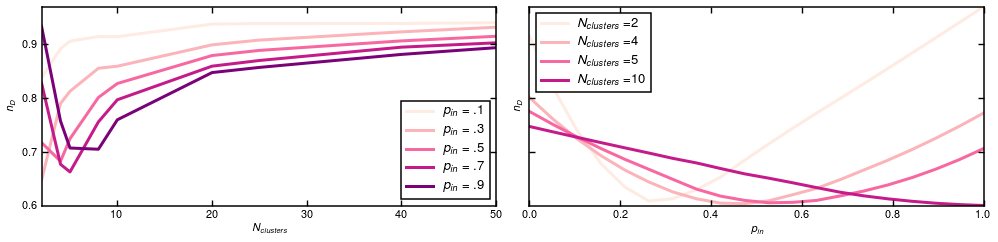

In [105]:
import mplp
from palettable.colorbrewer.sequential import RdPu_5
from scipy.signal import savgol_filter
l_width = 3
mfig = mplp.Mfig('normal', colors=RdPu_5)
#mfig.set_figsize('landscape', 1.5)
mfig.fig_size=(14,3.5)
fig, ax = mfig.subplots(1,2,sharey=True)
ax[0].plot( X, 1./N_nodes * data_subplot_1[0,:], linewidth = l_width, label = r'$p_{in} = .1$')
ax[0].plot( X, 1./N_nodes * data_subplot_1[1,:], linewidth = l_width, label = r'$p_{in} = .3$')
ax[0].plot( X, 1./N_nodes * data_subplot_1[2,:], linewidth = l_width, label = r'$p_{in} = .5$')
ax[0].plot( X, 1./N_nodes * data_subplot_1[3,:], linewidth = l_width, label = r'$p_{in} = .7$')
ax[0].plot( X, 1./N_nodes * data_subplot_1[4,:], linewidth = l_width, label = r'$p_{in} = .9$')

ax[0].set_xlabel(r'$N_{clusters}$')
ax[0].set_ylabel(r'$n_D$')
ax[0].set_xlim((2,50))
ax[0].legend(loc=4)
ax[0].set_yticks(np.arange(.6, 1, .1))

for i in range(data_subplot_2.shape[0]):
    ax[1].plot(X2, savgol_filter( 1./N_nodes * np.mean(data_subplot_2[i], axis = 1), 11, 2),
            linewidth = l_width, label=r'$N_{clusters} = $' + str(clust[i]) )

ax[1].set_xlabel(r'$p_{in}$')
ax[1].set_ylabel(r'$n_D$')

ax[1].legend(loc=2)

mfig.savefig("plot")

## Figure 6

In [124]:
with open('./figure_7/graphique_3_RANK_CONS.json', 'r') as f:
    RANK_CONS = json.load( f )
with open('./figure_7/graphique_3_TRACE_CONS.json', 'r') as f:
    TRACE_CONS = json.load( f )
with open('./figure_7/graphique_3_TRACE_INV_CONS.json', 'r') as f:
    TRACE_INV_CONS = json.load( f )

In [125]:
SIG_RANGE_1 = np.linspace(.01,12,5)
SIG_RANGE_2 = np.linspace(12,35,30)
SIG_RANGE_3 = np.linspace(35,50,5)
SIG_RANGE = np.append( SIG_RANGE_1, np.append( SIG_RANGE_2, SIG_RANGE_3 ) )
SIG_RANGE = np.unique( SIG_RANGE )
N_points  = len(SIG_RANGE)

In [126]:
TRACE_CONS     = np.array( TRACE_CONS )
TRACE_INV_CONS = np.array( TRACE_INV_CONS )
RANK_CONS      = np.array( RANK_CONS )

YY_TRACE_CONS     = savgol_filter( 1./N_nodes * np.mean( TRACE_CONS, axis = 1 ), 11, 3)
YY_TRACE_INV_CONS = savgol_filter( 1./N_nodes * np.mean( TRACE_INV_CONS, axis = 1 ), 11, 3)
YY_RANK_CONS      = savgol_filter( 1./N_nodes * np.mean( RANK_CONS, axis = 1 ), 11, 3)

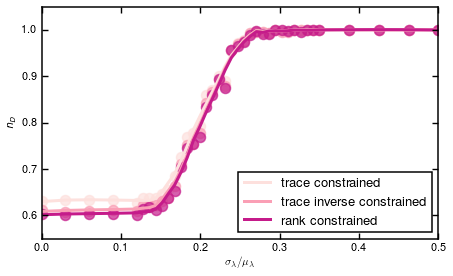

In [127]:
N_nodes  = 100
N_points = 20

from palettable.colorbrewer.sequential import RdPu_3
l_width = 3
mfig = mplp.Mfig('normal', colors=RdPu_3)
#mfig.fig_size=(9,5)
fig, ax = mfig.subplots()

ax.plot( 1./100 * SIG_RANGE, YY_TRACE_CONS,     linewidth = l_width, label = 'trace constrained' )
ax.plot( 1./100 * SIG_RANGE, YY_TRACE_INV_CONS, linewidth = l_width, label = 'trace inverse constrained' )
ax.plot( 1./100 * SIG_RANGE, YY_RANK_CONS,      linewidth = l_width, label = 'rank constrained' )
ax.scatter( 1./100 * SIG_RANGE, 1./N_nodes * np.mean( TRACE_CONS, axis = 1 ),     s=100, color = RdPu_3.hex_colors[0], alpha = .7)
ax.scatter( 1./100 * SIG_RANGE, 1./N_nodes * np.mean( TRACE_INV_CONS, axis = 1 ), s=100, color = RdPu_3.hex_colors[1], alpha = .7)
ax.scatter( 1./100 * SIG_RANGE, 1./N_nodes * np.mean( RANK_CONS, axis = 1 ),      s=100, color = RdPu_3.hex_colors[2], alpha = .7)


ax.set_xlabel(r'$ \sigma_{\lambda} / \mu_{\lambda} $')
ax.set_ylabel(r'$n_D$')
ax.legend( loc = 4)
ax.set_xlim((0,.5))
ax.set_ylim((.55,1.05))
mfig.savefig("plot2")